In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [54]:
def create_inception_module(input_tensor):
    # Define the Inception-like module with 4 parallel convolution channels
    
    conv1x1 = layers.Conv2D(64, (1, 1), activation='relu')(input_tensor)
    print("Success 1")
    conv3x3_reduce = layers.Conv2D(64, (1, 1), activation='relu')(input_tensor)
    print("Success 2")
    conv3x3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3x3_reduce)
    print("Success 3")
    conv5x5_reduce = layers.Conv2D(32, (1, 1), activation='relu')(input_tensor)
    print("Success 4")
    conv5x5 = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(conv5x5_reduce)
    print("Success 5")
    maxpool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(conv5x5)
    print("Success 6")
    maxpool_proj = layers.Conv2D(32, (1, 1), activation='relu')(maxpool)
    print("Success 7")

    # Concatenate the outputs of the parallel channels
    inception_module = layers.concatenate([conv1x1, conv3x3, conv5x5, maxpool_proj], axis=-1)
    print("Success 8")

    return inception_module


In [55]:


def create_siamese_branch(input_shape):
    # First, add a few convolutional layers

    '''layer1 = layers.Conv2D(32, (3, 3), activation='relu',padding = "valid")
    layer2 = layers.Conv2D(64, (3, 3), activation='relu', padding = "same")(layer1)'''
    input_layer = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu',padding = "valid")(input_layer)
    x = layers.Conv2D(32, (3, 3), activation='relu',padding = "valid")(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding = "same")(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding = "same")(x)
    x = layers.Conv2D(80, (3, 3), activation='relu', padding = "same" )(x)
    x = layers.Conv2D(80, (3, 3), activation='relu', padding = "same" )(x)
    x = layers.MaxPooling2D((3, 3))(x)

    # Add the Inception-like module here
    # print(model.layers[-1].output.shape[1:])
    x = create_inception_module(x)  # Pass the output of the last layer

    # Continue with more convolutional layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding = "same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    model = keras.Model(input_layer, [x])
    return model

In [86]:
model = create_siamese_branch((105,105,1))

model

Success 1
Success 2
Success 3
Success 4
Success 5
Success 6
Success 7
Success 8


In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 110, 110, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 108, 108, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [89]:
input_shape = (105, 105, 1)
# Define the Siamese network with two branches
branch_a = create_siamese_branch(input_shape)
branch_b = create_siamese_branch(input_shape)

# Define the inputs for the Siamese branches
input_a = keras.Input(shape=input_shape)
input_b = keras.Input(shape=input_shape)

# Get the outputs of the Siamese branches
output_a = branch_a(input_a)
output_b = branch_b(input_b)

Success 1
Success 2
Success 3
Success 4
Success 5
Success 6
Success 7
Success 8
Success 1
Success 2
Success 3
Success 4
Success 5
Success 6
Success 7
Success 8


In [110]:
def contrastive_loss(y_true, y_pred, margin=1):
    y_true = tf.cast(y_true, dtype=tf.float32)

    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)


In [100]:
L1_distance = tf.abs(output_a - output_b)


In [101]:
#Create the final output layer for your Siamese network, which predicts the similarity between the input pairs
prediction = keras.layers.Dense(1, activation='sigmoid')(L1_distance)

siamese_network = keras.Model(inputs=[input_a, input_b], outputs=prediction)


In [ ]:
# #Function to create pairs 
# def create_pairs(data, labels):
#     pairs, y = [], []
#     num_classes = max(labels) + 1
#     class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

#     for i in range(len(data)):
#         x1 = data[i]
#         label1 = labels[i]
#         x2 = data[np.random.choice(class_indices[label1])]
#         label2 = label1
#         pairs += [[x1, x2]]
#         y += [1]  # Similar pair

#         other_class = np.random.randint(0, num_classes)
#         x2 = data[np.random.choice(class_indices[other_class])]
#         label2 = other_class
#         pairs += [[x1, x2]]
#         y += [0]  # Dissimilar pair

#     return np.array(pairs), np.array(y)

# # Assuming you have a dataset and labels, you can create pairs like this
# pairs, y = create_pairs(your_data, your_labels)



In [63]:
import os
path = os.getcwd()
print(path)

directory_path = path  # Replace with the path to your directory
# C:\Users\Tanay Srivastava\Downloads\archive (8).zip\images_background\Greek
# Get a list of all files in the directory
file_paths = [os.path.join(directory_path, "Greek")]
# file_paths = [os.path.join(directory_path, filename) for filename in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, filename))]
all_files = []
for i in file_paths:
    for files in os.listdir(i):
        all_files.append(os.path.join(i, files))
# file_paths now contains the paths to all the files in the directory
print(file_paths)
print(all_files)
all_images = []
for i in all_files:
    for image in os.listdir(i):
      all_images.append(os.path.join(i, image))
# print(all_images)
# all_files = []  



c:\Users\Tanay Srivastava\Desktop\Project_1_DL
['c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek']
['c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek\\character01', 'c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek\\character02', 'c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek\\character03', 'c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek\\character04', 'c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek\\character05', 'c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek\\character06', 'c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek\\character07', 'c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek\\character08', 'c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek\\character09', 'c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek\\character10', 'c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek\\character11', 'c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek\\character12', 'c

In [64]:
def getSame(path_a, path_b):
    file_path_a = path_a
    file_path_b = path_b
    image_a = os.path.basename(file_path_a)
    image_b = os.path.basename(file_path_b)

    if image_a[0:4]==image_b[0:4]:
        return True
    else:
        return False



In [65]:
# make pairs with vectors
import random
random.shuffle(all_images)
vector_list = []
n = len(all_images)
final_dataset = []
i = 0;
while(n):
  n=n-2;
  selected_paths =all_images[i:i+2]
  i = i+2;
  #check whether the 2 files are from same class or not

  a = getSame(selected_paths[0],selected_paths[1])
  if(a):
    selected_paths.append(1)
  else:
    selected_paths.append(0)

  final_dataset.append(selected_paths)

print(final_dataset[0])

['c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek\\character21\\0414_19.png', 'c:\\Users\\Tanay Srivastava\\Desktop\\Project_1_DL\\Greek\\character20\\0413_02.png', 0]


In [93]:
siamese_network.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_10 (InputLayer)          [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_5 (Functional)           (None, 128)          18483200    ['input_9[0][0]']                
                                                                                            

In [111]:
siamese_network.compile(loss=contrastive_loss, optimizer="adam", metrics='accuracy')

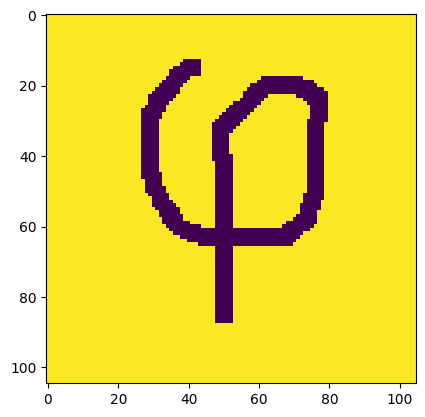

In [103]:
a = plt.imread(final_dataset[0][0])
plt.imshow(a)

In [112]:
# Assuming you have a list of pairs (image1, image2) and corresponding target values in final_dataset
batch_size = 32  # Choose an appropriate batch size

for i in range(0, len(final_dataset), batch_size):
    batch = final_dataset[i:i + batch_size]

    input_batch = []
    target_batch = []

    for data in batch:
        s1, s2, value = data

        image1 = plt.imread(s1) / 255.0
        image2 = plt.imread(s2) / 255.0

        image1 = np.expand_dims(image1, -1)
        image2 = np.expand_dims(image2, -1)

        input_batch.append([image1, image2])
        target_batch.append(value)

    input_batch = [np.array(input_batch) for input_batch in zip(*input_batch)]
    target_batch = np.array(target_batch)

    siamese_network.fit(input_batch, target_batch, epochs=1)


1/1 [==============================] - 10s 10s/step - loss: 0.1691 - accuracy: 0.0000e+00


In [113]:
#Train Siamese network with your data pairs and labels.

# siamese_network.fit([pairs[:, 0], pairs[:, 1]], y, epochs=100, batch_size=10)



In [ ]:
model